In [64]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc

In [97]:
adata = sc.read_h5ad('../data/pdac/all_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 33912 × 2999
    obs: 'sample_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'type', 'leiden', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'gene_ids-10', 'feature_types-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'feature_types-7', 'gene_ids-8', 'feature_types-8', 'gene_ids-9', 'feature_types-9', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colo

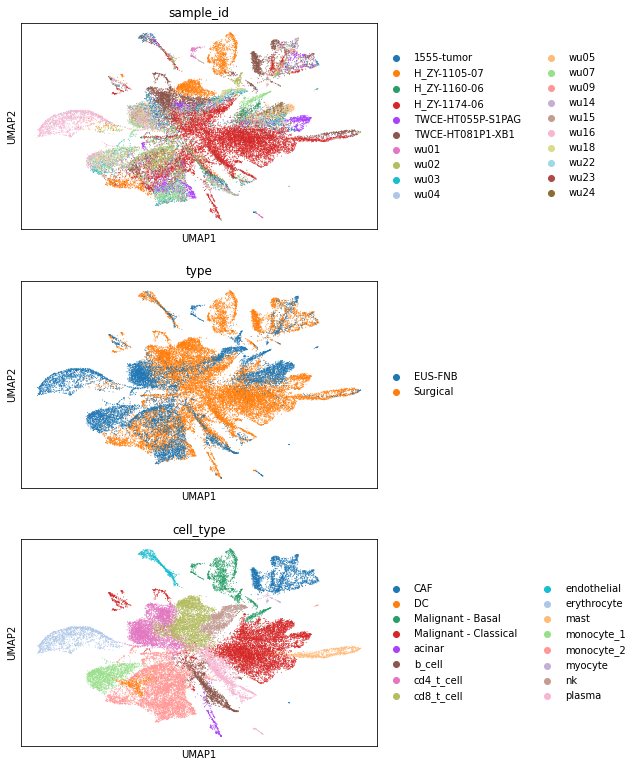

In [98]:
sc.pl.umap(adata, color=['sample_id', 'type', 'cell_type'], ncols=1)

## cibersortx file prep

#### sc reference prep

In [67]:
# restrict the sc reference to top 3k variably expressed and top 100 genes diff expressed by basal

In [6]:
mask = [True if 'malignant' in x.lower() else False for x in adata.obs['cell_type']]
malignant = adata[mask].copy()
malignant

AnnData object with n_obs × n_vars = 8876 × 2999
    obs: 'sample_id', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'type', 'leiden', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'gene_ids-10', 'feature_types-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'feature_types-7', 'gene_ids-8', 'feature_types-8', 'gene_ids-9', 'feature_types-9', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden',

In [8]:
sc.tl.rank_genes_groups(malignant, 'cell_type', method='wilcoxon')

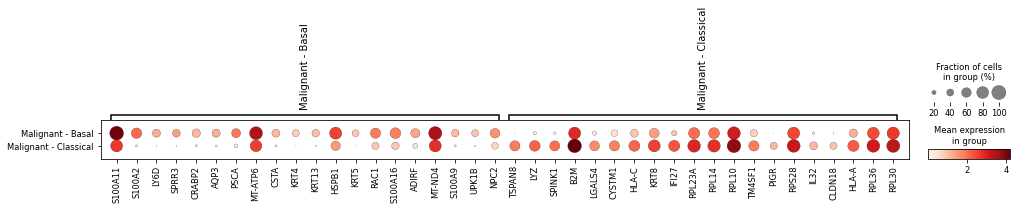

In [10]:
sc.pl.rank_genes_groups_dotplot(malignant, n_genes=20)

In [22]:
top_100_squam = malignant.uns['rank_genes_groups']['names']['Malignant - Basal'][:100]
top_100_classical = malignant.uns['rank_genes_groups']['names']['Malignant - Classical'][:100]
top_100_squam, top_100_classical

(array(['S100A11', 'S100A2', 'LY6D', 'SPRR3', 'CRABP2', 'AQP3', 'PSCA',
        'MT-ATP6', 'CSTA', 'KRT4', 'KRT13', 'HSPB1', 'KRT5', 'RAC1',
        'S100A16', 'ADIRF', 'MT-ND4', 'S100A9', 'UPK1B', 'NPC2', 'FSCN1',
        'ARPC2', 'CSTB', 'SDC1', 'KRT6A', 'KRT17', 'CXCL17', 'HSP90AA1',
        'OST4', 'GLUL', 'LDHB', 'BZW1', 'SNCG', 'CCND1', 'NDUFA4',
        'MT-CO2', 'SPRR1B', 'CYCS', 'CEACAM7', 'TOMM7', 'MIR4435-2HG',
        'CBX3', 'S100A4', 'PPIA', 'CD9', 'DHRS9', 'GAPDH', 'CTNNBIP1',
        'STRAP', 'NDUFA3', 'CALML5', 'C7orf50', 'PHLDA3', 'HES1',
        'ALDH1L1', 'CTSD', 'RTN4', 'POLR2L', 'CST3', 'SEPT7', 'AP2S1',
        'MALL', 'WDR72', 'IGFBP2', 'PTGES', 'MRPL51', 'CRIP2', 'SLIRP',
        'NCCRP1', 'HCLS1', 'TCEAL4', 'NUDT1', 'TPD52L2', 'KRT15', 'RPL37A',
        'TSPAN6', 'PSMG3', 'MTRNR2L1', 'TPI1', 'POLR2J3', 'AHNAK2',
        'GPNMB', 'ATOX1', 'SEC61G', 'KRT7', 'TFPT', 'MT-ND4L', 'MT-ATP8',
        'DYNC1I2', 'ROMO1', 'LAMP1', 'ERGIC2', 'SOX15', 'AP3M2', 'EFHD2',
  

In [23]:
genes = list(top_100_squam) + list(top_100_classical)
genes += adata.var.index.to_list()
len(genes)

3199

In [99]:
#reload in the raw counts
raw_counts = sc.read_h5ad('../data/pdac/m1.h5ad')
raw_counts

AnnData object with n_obs × n_vars = 19331528 × 22164
    obs: 'sample_id', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'gene_ids-10', 'feature_types-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'feature_types-7', 'gene_ids-8', 'feature_types-8', 'gene_ids-9', 'feature_types-9'

In [100]:
# keep only cells we filtered to
filtered = raw_counts[adata.obs.index]
filtered

View of AnnData object with n_obs × n_vars = 33912 × 22164
    obs: 'sample_id', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'gene_ids-10', 'feature_types-10', 'gene_ids-11', 'feature_types-11', 'gene_ids-12', 'feature_types-12', 'gene_ids-13', 'feature_types-13', 'gene_ids-14', 'feature_types-14', 'gene_ids-15', 'feature_types-15', 'gene_ids-16', 'feature_types-16', 'gene_ids-17', 'feature_types-17', 'gene_ids-18', 'feature_types-18', 'gene_ids-19', 'feature_types-19', 'gene_ids-2', 'gene_ids-20', 'feature_types-20', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'feature_types-7', 'gene_ids-8', 'feature_types-8', 'gene_ids-9', 'feature_types-9'

In [101]:
set(filtered.X[:1].toarray().flatten())

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 29.0,
 31.0,
 33.0,
 34.0,
 41.0,
 52.0,
 58.0,
 67.0}

In [102]:
df = pd.DataFrame(data=filtered.X.toarray(), index=filtered.obs.index, columns=filtered.var.index)
df = df.transpose()
df

,AAACCTGAGACCTAGG-1-0,AAACCTGAGTGCGTGA-1-0,AAACCTGCATCCCACT-1-0,AAACCTGTCCGGGTGT-1-0,AAACGGGAGACAATAC-1-0,AAACGGGAGGCGCTCT-1-0,AAACGGGAGGGTATCG-1-0,AAACGGGGTGAGTGAC-1-0,AAACGGGTCTCGCATC-1-0,AAAGATGCACCAGGTC-1-0,...,TTCTACAGTATAAACG-1-20,TTCTACATCCACGCAG-1-20,TTGAACGAGAGAACAG-1-20,TTGAACGTCCGAGCCA-1-20,TTTACTGCATAGACTC-1-20,TTTCCTCGTACAGTGG-1-20,TTTCCTCGTGTGACGA-1-20,TTTGGTTAGAACTGTA-1-20,TTTGGTTAGATGTGGC-1-20,TTTGTCAGTTCCACGG-1-20
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC240274.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# replace ids with cell types
cell_to_type = {c:t for c, t in zip(adata.obs.index, adata.obs['cell_type'])}
cols = [cell_to_type[c].replace(' - ', '_') for c in df.columns]
# # change names to three classes, and reformat so they work with cibersortx
# def assign_label(c):
#     if 'malignant' in c.lower():
#         if 'basal' in c.lower():
#             return 'malignant_basal'
#         else:
#             return 'malignant_classical'
#     return 'other'
# cols = [assign_label(c) for c in cols]
from collections import Counter
Counter(cols).most_common()

[('Malignant_Classical', 7376),
 ('monocyte_2', 6135),
 ('cd8_t_cell', 3711),
 ('cd4_t_cell', 3626),
 ('CAF', 2013),
 ('plasma', 1639),
 ('monocyte_1', 1555),
 ('Malignant_Basal', 1500),
 ('b_cell', 1415),
 ('erythrocyte', 1400),
 ('nk', 1390),
 ('mast', 853),
 ('endothelial', 543),
 ('DC', 463),
 ('acinar', 228),
 ('myocyte', 65)]

In [104]:
df.columns = cols
df

,nk,Malignant_Classical,cd4_t_cell,nk,Malignant_Classical,nk,cd4_t_cell,CAF,b_cell,cd4_t_cell,...,Malignant_Classical,Malignant_Classical,monocyte_2,CAF,Malignant_Classical,Malignant_Classical,Malignant_Classical,Malignant_Classical,CAF,Malignant_Classical
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC240274.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
AC213203.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
df.index.name = 'Gene'

In [106]:
len(set(df.index))

22164

In [107]:
df.to_csv('../data/cibersortx/sc_ref_combined_allgenes.tsv', sep='\t')

In [90]:
###### prepare cytotrace
tumor_only

,AAACCTGAGACCTAGG-1-0,AAACCTGAGTGCGTGA-1-0,AAACCTGCATCCCACT-1-0,AAACCTGTCCGGGTGT-1-0,AAACGGGAGACAATAC-1-0,AAACGGGAGGCGCTCT-1-0,AAACGGGAGGGTATCG-1-0,AAACGGGGTGAGTGAC-1-0,AAACGGGTCTCGCATC-1-0,AAAGATGCACCAGGTC-1-0,...,TTCTACAGTATAAACG-1-20,TTCTACATCCACGCAG-1-20,TTGAACGAGAGAACAG-1-20,TTGAACGTCCGAGCCA-1-20,TTTACTGCATAGACTC-1-20,TTTCCTCGTACAGTGG-1-20,TTTCCTCGTGTGACGA-1-20,TTTGGTTAGAACTGTA-1-20,TTTGGTTAGATGTGGC-1-20,TTTGTCAGTTCCACGG-1-20
Gene,,,,,,,,,,,,,,,,,,,,,
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC240274.1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
[c for c, i in zip(adata.obs.index, adata.obs['cell_type']) if 'Malignant' in c]

[]

In [93]:
tumor_only = df.copy()
tumor_only.columns = adata.obs.index.to_list()
tumor_only = tumor_only.loc[:, [c for c, i in zip(adata.obs.index, adata.obs['cell_type']) if 'Malignant' in i]]
tumor_only

,AAACCTGAGTGCGTGA-1-0,AAACGGGAGACAATAC-1-0,AACCGCGAGCAATCTC-1-0,AACCGCGTCTTTAGTC-1-0,AACTCCCCAAACAACA-1-0,AAGCCGCAGACGCTTT-1-0,AAGCCGCTCATTGCGA-1-0,AAGCCGCTCTTCTGGC-1-0,AAGTCTGAGTAGTGCG-1-0,AATCCAGCAAACTGCT-1-0,...,TTATGCTGTAGTGAAT-1-20,TTCGAAGGTAGGCTGA-1-20,TTCGGTCAGATCCTGT-1-20,TTCTACAGTATAAACG-1-20,TTCTACATCCACGCAG-1-20,TTTACTGCATAGACTC-1-20,TTTCCTCGTACAGTGG-1-20,TTTCCTCGTGTGACGA-1-20,TTTGGTTAGAACTGTA-1-20,TTTGTCAGTTCCACGG-1-20
Gene,,,,,,,,,,,,,,,,,,,,,
FAM138A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OR4F16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FAM87B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC233755.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC240274.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
tumor_only.to_csv('../data/cytotrace/cytotrace_combined.tsv', sep='\t')

#### prepare bulk matrices

In [42]:
tcga = pd.read_csv('../data/bulk_rna_seq/tcga.txt', sep='\t', index_col='Gene')
tcga

,TCGA-OE-A75W-01A-12R-A32O-07,TCGA-2J-AABT-01A-11R-A41B-07,TCGA-IB-7886-01A-11R-2156-07,TCGA-IB-AAUU-01A-11R-A37L-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-LB-A8F3-01A-11R-A36G-07,TCGA-HZ-A4BH-01A-11R-A26U-07,TCGA-HV-A5A3-11A-11R-A26U-07,TCGA-IB-7646-01A-11R-2156-07,TCGA-2J-AAB9-01A-11R-A41B-07,...,TCGA-L1-A7W4-01A-12R-A36G-07,TCGA-IB-A5SO-01A-11R-A32O-07,TCGA-IB-AAUW-01A-12R-A38C-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-H8-A6C1-01A-11R-A32O-07,TCGA-IB-AAUN-01A-12R-A38C-07,TCGA-FB-AAPU-01A-31R-A41B-07,TCGA-HZ-8001-01A-11R-2204-07,TCGA-IB-7651-01A-11R-2156-07,TCGA-3A-A9IJ-01A-11R-A39D-07
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.41,0.11,0.07,0.12,0.17,0.13,0.28,0.26,0.06,0.17,...,0.68,0.42,0.36,0.36,0.54,0.14,0.03,0.23,0.28,2.05
A1BG-AS1,1.51,1.10,0.73,0.84,1.19,0.44,1.55,1.61,0.44,1.56,...,1.79,1.43,1.70,2.00,1.38,0.82,0.27,1.50,1.60,2.58
A1CF,3.17,5.20,17.23,12.65,1.99,12.87,10.41,4.12,0.50,4.00,...,0.16,1.94,19.68,21.56,3.74,2.65,17.77,5.76,2.35,36.73
A2M,464.50,1177.62,791.41,531.79,370.69,799.84,970.75,1378.72,746.49,1027.80,...,394.49,1091.17,1034.47,919.86,607.21,572.43,271.54,1250.65,1916.74,311.04
A2M-AS1,0.65,2.92,0.86,0.76,0.75,0.30,0.72,1.49,1.06,1.09,...,0.45,1.41,1.61,1.33,0.91,1.31,0.31,1.15,1.00,2.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.08,0.03,0.00,0.08,0.05,0.00,0.00,0.05,0.06,0.04,...,1.75,0.05,0.04,0.10,0.07,0.07,0.02,0.10,0.05,0.49
ZYG11B,13.00,50.75,36.75,31.48,31.99,13.16,32.73,30.98,31.74,28.16,...,34.46,27.88,41.68,35.72,29.35,25.08,28.01,22.89,42.44,50.54
ZYX,354.23,557.21,246.15,430.63,507.73,262.34,314.66,438.94,154.36,345.79,...,136.42,223.85,206.28,301.77,163.73,215.82,229.96,365.41,182.42,63.77


In [43]:
np.sum(tcga.values, axis=0)

array([ 999993.62, 1000001.76, 1000005.81, 1000007.75,  999993.38,
       1000006.24,  999995.3 ,  999996.94,  999995.67,  999994.81,
       1000004.73, 1000000.35,  999999.09, 1000008.03,  999993.67,
       1000005.38,  999995.08, 1000004.87,  999997.17, 1000008.51,
        999995.45, 1000000.73, 1000000.29,  999994.26, 1000005.81,
        999999.95, 1000002.93, 1000000.27,  999993.38,  999992.52,
       1000007.14,  999997.27, 1000006.88,  999992.29,  999999.44,
        999994.34, 1000008.32,  999993.78, 1000006.31,  999991.01,
       1000007.07,  999993.1 ,  999995.31,  999990.94,  999995.49,
       1000009.27,  999992.28, 1000000.32, 1000010.17,  999993.38,
        999992.11, 1000003.41,  999990.91,  999983.32,  999997.05,
       1000007.84,  999996.87,  999984.09, 1000002.96,  999991.39,
        999997.97, 1000006.97,  999995.47,  999993.02,  999992.43,
        999992.88, 1000006.5 , 1000006.34, 1000009.53, 1000001.85,
        999993.36,  999984.73,  999994.85, 1000006.97, 1000003

In [44]:
tcga.index.name = 'Gene'

In [46]:
tcga = tcga.groupby('Gene').mean()
tcga

,TCGA-OE-A75W-01A-12R-A32O-07,TCGA-2J-AABT-01A-11R-A41B-07,TCGA-IB-7886-01A-11R-2156-07,TCGA-IB-AAUU-01A-11R-A37L-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-LB-A8F3-01A-11R-A36G-07,TCGA-HZ-A4BH-01A-11R-A26U-07,TCGA-HV-A5A3-11A-11R-A26U-07,TCGA-IB-7646-01A-11R-2156-07,TCGA-2J-AAB9-01A-11R-A41B-07,...,TCGA-L1-A7W4-01A-12R-A36G-07,TCGA-IB-A5SO-01A-11R-A32O-07,TCGA-IB-AAUW-01A-12R-A38C-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-H8-A6C1-01A-11R-A32O-07,TCGA-IB-AAUN-01A-12R-A38C-07,TCGA-FB-AAPU-01A-31R-A41B-07,TCGA-HZ-8001-01A-11R-2204-07,TCGA-IB-7651-01A-11R-2156-07,TCGA-3A-A9IJ-01A-11R-A39D-07
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.41,0.11,0.07,0.12,0.17,0.13,0.28,0.26,0.06,0.17,...,0.68,0.42,0.36,0.36,0.54,0.14,0.03,0.23,0.28,2.05
A1BG-AS1,1.51,1.10,0.73,0.84,1.19,0.44,1.55,1.61,0.44,1.56,...,1.79,1.43,1.70,2.00,1.38,0.82,0.27,1.50,1.60,2.58
A1CF,3.17,5.20,17.23,12.65,1.99,12.87,10.41,4.12,0.50,4.00,...,0.16,1.94,19.68,21.56,3.74,2.65,17.77,5.76,2.35,36.73
A2M,464.50,1177.62,791.41,531.79,370.69,799.84,970.75,1378.72,746.49,1027.80,...,394.49,1091.17,1034.47,919.86,607.21,572.43,271.54,1250.65,1916.74,311.04
A2M-AS1,0.65,2.92,0.86,0.76,0.75,0.30,0.72,1.49,1.06,1.09,...,0.45,1.41,1.61,1.33,0.91,1.31,0.31,1.15,1.00,2.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.08,0.03,0.00,0.08,0.05,0.00,0.00,0.05,0.06,0.04,...,1.75,0.05,0.04,0.10,0.07,0.07,0.02,0.10,0.05,0.49
ZYG11B,13.00,50.75,36.75,31.48,31.99,13.16,32.73,30.98,31.74,28.16,...,34.46,27.88,41.68,35.72,29.35,25.08,28.01,22.89,42.44,50.54
ZYX,354.23,557.21,246.15,430.63,507.73,262.34,314.66,438.94,154.36,345.79,...,136.42,223.85,206.28,301.77,163.73,215.82,229.96,365.41,182.42,63.77


In [48]:
tcga.to_csv('../data/cibersortx/tcga_bulk_mixture.txt', sep='\t', header=True, index=True)

In [49]:
bailey = pd.read_csv('../data/bulk_rna_seq/bailey.txt', sep='\t', index_col='Gene')
bailey

,SA518851,SA528771,SA528766,SA528763,SA518817,SA518765,SA518854,SA518806,SA528767,SA518750,...,SA412299,SA411841,SA411797,SA411769,SA411833,SA411430,SA411406,SA411923,SA411305,SA411682
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,34.271786,8.432164,12.035700,16.535448,32.447517,21.941076,31.505297,50.970730,21.511930,15.687231,...,84.090195,44.252280,26.427183,26.171358,14.654242,23.046831,31.303656,53.031040,32.834440,95.830765
TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.570220,0.000000,0.000000,0.000000,0.172387,...,0.026866,0.000000,0.100356,0.000000,0.023867,0.000000,0.000000,0.000000,0.029661,0.000000
DPM1,47.353447,12.707628,7.406585,10.908201,26.380407,39.196430,30.702614,26.793766,11.090595,19.393555,...,26.436022,56.707830,57.069332,18.517822,23.795244,59.639557,21.125784,39.263367,47.279220,54.543990
SCYL3,9.549973,28.146803,19.905197,16.622020,24.690832,22.412128,26.127323,32.141140,36.618084,25.082330,...,36.886850,10.306527,29.638586,17.547130,34.750126,17.920088,25.645563,14.175605,19.160840,13.203109
C1orf112,15.964670,13.420205,10.184054,8.830448,9.791854,11.156480,14.368021,10.979186,23.232885,10.084649,...,10.289631,23.025220,13.916086,6.869515,10.787814,9.642042,7.466006,13.155777,18.122713,44.371105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC008735.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.026866,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC245884.10,0.036038,0.475052,0.000000,0.346292,0.230397,0.247922,0.080268,0.455096,0.860477,1.551484,...,0.000000,0.000000,0.066904,0.000000,0.095467,0.094069,0.100440,0.203966,0.000000,0.054111
AC008753.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.024792,0.000000,0.113774,0.000000,0.000000,...,0.000000,0.000000,0.033452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
np.sum(bailey.values, axis=0)

array([ 999999.97581755,  999999.96294053, 1000000.02464155,
        999999.96315194, 1000000.03451771,  999999.9437105 ,
       1000000.01141665, 1000000.04073622,  999999.95722733,
        999999.88374071,  999999.98587294,  999999.97153494,
       1000000.0042878 , 1000000.08027928, 1000000.01878616,
        999999.9860619 , 1000000.09256661,  999999.96478356,
       1000000.05837736,  999999.98761483, 1000000.06081209,
        999999.96759208,  999999.92494856,  999999.84175552,
       1000000.00003303, 1000000.02651884,  999999.98531443,
        999999.95922833,  999999.9082762 ,  999999.95707487,
       1000000.02218649, 1000000.00320957,  999999.98880943,
       1000000.02437578,  999999.97676429, 1000000.0759484 ,
        999999.92799672,  999999.99358697, 1000000.00941315,
       1000000.04041583, 1000000.03709052,  999999.98233644,
       1000000.07647589, 1000000.02222139, 1000000.06628783,
       1000000.01348332, 1000000.02083122, 1000000.02848435,
       1000000.08171851,

In [51]:
bailey.index.name = 'Gene'

In [52]:
bailey = bailey.groupby('Gene').mean()
bailey

,SA518851,SA528771,SA528766,SA528763,SA518817,SA518765,SA518854,SA518806,SA528767,SA518750,...,SA412299,SA411841,SA411797,SA411769,SA411833,SA411430,SA411406,SA411923,SA411305,SA411682
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,1.873957,1.781443,1.851646,1.125449,1.267181,0.842934,0.963219,0.967079,2.390214,1.163613,...,3.788089,0.131573,1.538798,1.456039,0.883073,1.269927,1.874871,2.855517,1.305073,0.216444
A1BG-AS1,1.117167,0.950103,0.925823,2.077753,1.267181,0.991687,0.963219,0.511983,2.390214,0.775742,...,1.638818,0.000000,1.471894,2.053387,1.527478,0.893653,2.879267,3.824354,1.305073,0.270556
A1CF,0.000000,3.206598,3.240381,6.406404,3.225552,1.661076,1.083622,0.113774,8.795989,6.119744,...,2.471661,0.000000,7.292564,29.643450,2.577619,6.584809,2.644908,2.498578,1.334733,0.108222
A2M,246.677580,140.021440,97.674330,318.155850,461.791500,763.251950,921.399540,228.799410,427.083530,887.750800,...,236.043580,0.000000,245.070300,613.029500,689.298340,647.710000,960.637200,647.641540,359.784800,2.326777
A2M-AS1,0.468489,1.662680,0.925823,1.991179,0.767989,2.181712,1.444829,2.673688,2.198997,4.223486,...,0.134329,0.131573,1.471894,1.082695,0.883073,0.235172,2.109230,0.866854,0.593215,0.216444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,27.136335,50.236700,54.160652,31.339434,28.031582,32.899220,41.619100,55.407913,40.538036,41.631500,...,39.949560,11.622254,40.142555,34.198235,29.356220,33.770664,38.100063,43.903580,37.906425,14.988775
ZYG11A,0.396414,4.275464,4.166204,2.337472,0.844787,0.619804,1.163890,1.080852,6.692601,1.077420,...,0.268659,0.043858,0.802851,0.709352,0.668272,0.282206,0.401758,1.376767,0.474572,4.815888
ZYG11B,76.435814,48.336490,51.846092,67.267235,75.685270,74.004650,77.338480,73.497970,64.248960,121.791530,...,53.543690,41.664684,56.132675,64.849710,78.307120,54.795017,59.594128,84.084790,119.147194,69.586876


In [53]:
bailey.to_csv('../data/cibersortx/bailey_bulk_mixture.txt', sep='\t', header=True, index=True)

In [54]:
moffit = pd.read_csv('../data/bulk_rna_seq/moffit.txt', sep='\t', index_col='Gene')
moffit

,GSM1844105,GSM1844106,GSM1844107,GSM1844108,GSM1844109,GSM1844110,GSM1844111,GSM1844112,GSM1844113,GSM1844114,...,GSM1844240,GSM1844241,GSM1844242,GSM1844243,GSM1844244,GSM1844245,GSM1844246,GSM1844247,GSM1844248,GSM1844249
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,2.657,3.550,2.490,2.613,2.865,2.985,3.539,2.642,3.620,2.767,...,2.677,2.869,3.328,3.541,2.941,3.618,3.261,3.946,3.503,3.769
A1CF,1.492,2.106,2.083,3.482,4.220,4.232,2.293,2.914,2.057,1.192,...,1.207,1.140,2.276,1.346,2.414,2.095,1.777,5.169,1.431,2.498
A2BP1,1.390,0.873,0.925,0.984,0.808,0.744,0.766,0.943,1.221,0.511,...,1.505,0.877,1.470,1.506,0.747,1.091,1.216,1.456,1.681,1.099
A2LD1,2.493,3.894,3.909,3.036,4.840,4.818,2.642,3.512,4.190,3.069,...,3.456,3.176,3.378,4.145,3.588,3.901,3.066,3.262,2.742,5.516
A2M,9.564,9.028,9.611,10.565,9.042,9.393,10.853,5.750,9.768,11.212,...,10.854,10.611,9.992,9.150,11.209,11.881,11.527,10.438,8.931,8.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.739,0.428,0.961,0.363,0.682,0.515,0.574,0.268,0.389,0.363,...,0.849,1.024,0.380,0.787,0.464,0.687,0.400,0.389,0.601,0.347
ZYG11B,2.808,2.549,2.966,2.707,2.957,2.919,2.555,1.985,2.825,3.445,...,2.710,2.828,2.355,2.610,2.783,3.239,3.129,2.982,2.162,2.856
ZYX,3.754,3.853,3.235,4.963,3.389,2.612,4.118,3.335,4.232,4.984,...,3.379,4.791,2.878,2.902,3.707,3.889,3.342,2.737,3.247,3.050


In [55]:
np.sum(moffit.values, axis=0)

array([63931.632, 65549.313, 66483.081, 66624.647, 64556.644, 66041.615,
       65612.32 , 65046.622, 66508.125, 64679.345, 66229.129, 66662.377,
       67021.92 , 66060.454, 67243.719, 66697.927, 66148.762, 66624.762,
       67533.634, 66900.167, 66156.742, 65946.12 , 65524.108, 65734.765,
       66417.698, 63521.701, 65536.79 , 66849.859, 65413.341, 66514.805,
       67293.853, 66686.554, 66036.407, 66520.12 , 66814.094, 66441.648,
       67022.917, 64846.708, 67387.395, 64701.769, 66629.101, 64958.817,
       65689.281, 65588.506, 67516.169, 64391.811, 65992.111, 66429.711,
       64842.186, 66206.276, 66241.913, 65507.87 , 66731.087, 66484.956,
       66731.524, 65207.323, 65768.712, 66708.177, 66545.483, 66229.094,
       65729.244, 64984.256, 66551.931, 67570.7  , 66406.777, 67279.247,
       66415.158, 66847.85 , 66632.11 , 66639.359, 64889.87 , 66794.352,
       65687.89 , 67226.413, 67021.925, 64420.317, 66652.029, 66418.185,
       65013.401, 64139.215, 66579.907, 65465.019, 

In [56]:
moffit.index.name = 'Gene'

In [57]:
moffit = moffit.groupby('Gene').mean()
moffit

,GSM1844105,GSM1844106,GSM1844107,GSM1844108,GSM1844109,GSM1844110,GSM1844111,GSM1844112,GSM1844113,GSM1844114,...,GSM1844240,GSM1844241,GSM1844242,GSM1844243,GSM1844244,GSM1844245,GSM1844246,GSM1844247,GSM1844248,GSM1844249
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,2.657,3.550,2.490,2.613,2.865,2.985,3.539,2.642,3.620,2.767,...,2.677,2.869,3.328,3.541,2.941,3.618,3.261,3.946,3.503,3.769
A1CF,1.492,2.106,2.083,3.482,4.220,4.232,2.293,2.914,2.057,1.192,...,1.207,1.140,2.276,1.346,2.414,2.095,1.777,5.169,1.431,2.498
A2BP1,1.390,0.873,0.925,0.984,0.808,0.744,0.766,0.943,1.221,0.511,...,1.505,0.877,1.470,1.506,0.747,1.091,1.216,1.456,1.681,1.099
A2LD1,2.493,3.894,3.909,3.036,4.840,4.818,2.642,3.512,4.190,3.069,...,3.456,3.176,3.378,4.145,3.588,3.901,3.066,3.262,2.742,5.516
A2M,9.564,9.028,9.611,10.565,9.042,9.393,10.853,5.750,9.768,11.212,...,10.854,10.611,9.992,9.150,11.209,11.881,11.527,10.438,8.931,8.519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tcag7.23,7.698,7.709,6.694,7.172,8.555,7.807,7.566,8.145,7.511,7.255,...,6.765,6.726,6.636,6.583,7.140,6.877,7.044,6.722,6.739,7.473
tcag7.350,9.227,8.970,7.635,8.249,9.046,9.096,8.060,7.771,8.424,8.240,...,8.928,8.369,8.347,8.631,8.662,9.038,9.082,8.547,8.845,8.807
tcag7.873,6.561,6.984,5.373,4.423,3.676,6.008,4.867,5.485,4.411,3.054,...,6.563,4.455,6.208,7.048,7.606,7.319,6.470,6.449,6.246,5.738


In [58]:
moffit.to_csv('../data/cibersortx/moffit_bulk_mixture.txt', sep='\t', header=True, index=True)

#### save gene list

In [62]:
f = open('../data/cibersortx/gene_list.txt', 'w')
for g in top_100_squam: f.write(f'{g}\n')
f.close()

In [63]:
# df[[]].to_csv('../data/cibersortx/gene_list.txt', sep='\t', index=True, header=False)